In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from utils import extract_frame
from scipy.optimize import curve_fit
# %matplotlib notebook

In [99]:
problem = {2:(np.array([
    [  1.15422732e+03,   0.00000000e+00,   6.71627794e+02],
 [  0.00000000e+00,   1.14818221e+03,   3.86046312e+02],
 [  0.00000000e+00 ,  0.00000000e+00,   1.00000000e+00]
]),np.array([ -2.42565104e-01,  -4.77893070e-02,  -1.31388084e-03,  -8.79107779e-05, 2.20573263e-02]),400,np.array([
    [100,800],
    [100,900],
    [700,800],
    [700,900]
], dtype = np.float32),np.array([
    [583,100],
    [304,247],
    [745,100],
    [967,304]
], dtype = np.float32)),1:(np.array([[903.7596,   0.    , 695.7519],
[  0.    , 901.9653, 224.2509],
[  0.    ,   0.    ,   1.    ]]),np.array([-0.3639558 ,  0.1788651 ,  0.00060297, -0.00039224, -0.0538246 ]),\
    250,np.array([
   [100,0],
    [100,900],
    [700,0],
    [700,900]
], dtype = np.float32),np.array([
    [610,0],
    [110,260],
    [695,0],
    [933,260],
], dtype = np.float32))}

def preprocess(img):
    undistorted = cv2.undistort(img, K, D)
    gauss = cv2.GaussianBlur(undistorted,(7,7),1)
    gauss = cv2.cvtColor(gauss, cv2.COLOR_BGR2RGB)
    hls = cv2.cvtColor(gauss, cv2.COLOR_RGB2HLS)

    whitel = np.array([180,180,180])
    whiteh = np.array([255,255,255])
    mask_white = cv2.inRange(gauss, whitel, whiteh)

    yellowl = np.array([15, 100, 70])
    yellowh = np.array([50, 210, 255])
    mask_yellow = cv2.inRange(hls, yellowl, yellowh)

    mask = np.zeros(gauss.shape[:-1])
    mask[(mask_white==255)|(mask_yellow==255)]=255
    
    return mask

def polyfit(sobel, margin=25):
    left = sobel[:,:(sobel.shape[1]//2-margin)]
    right = sobel[:,(sobel.shape[1]//2+margin):]
    ly,lx = np.nonzero(left)
    ry, rx = np.nonzero(right)
    rx= rx+sobel.shape[1]//2
    left_fit = np.polyfit(ly, lx, 2)
    right_fit = np.polyfit(ry, rx, 2)
    left_der1 = np.polyder(np.poly1d(left_fit),1)
    left_der2 = np.polyder(np.poly1d(left_fit),2)
    right_der1 = np.polyder(np.poly1d(right_fit),1)
    right_der2 = np.polyder(np.poly1d(right_fit),2)
    
    y = 100
    
    radius_l = (1+left_der2(y))**1.5/(np.absolute(left_der1(y)))
    radius_r = (1+right_der2(y))**1.5/(np.absolute(right_der1(y)))
    
    radius = (radius_l+radius_r)/2
    
    return left_fit, right_fit,radius
    

def overlay_lanes(img,sobel, hinv, left_curve, right_curve, color = (255,0,0)):
    
    ploty = np.linspace(0, sobel.shape[0]-1, sobel.shape[0] )
    left_fitx = left_curve[0]*ploty**2 + left_curve[1]*ploty + left_curve[2]
    right_fitx = right_curve[0]*ploty**2 + right_curve[1]*ploty + right_curve[2]
    
    
    zeros = np.zeros(sobel.shape).astype(np.uint8)
    color_warp =np.dstack((zeros, zeros, zeros))
    
    left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((left, right))

    cv2.fillPoly(color_warp, np.int_([pts]), color)
    unwarp = cv2.warpPerspective(color_warp, hinv, (img.shape[1],img.shape[0])).astype(np.uint8)
    
    return cv2.addWeighted(img, 1, unwarp, 0.3, 0)

def lane_segmentation(raw_img, crop, source, destination):
    
    mask = preprocess(image)[crop:]
    h = cv2.getPerspectiveTransform(source, destination)
    hinv = cv2.getPerspectiveTransform(destination,source)
    warp = cv2.warpPerspective(mask, h, (900, 900)).astype(np.uint8)
    sobel = cv2.Sobel(warp,-1,1,0)
    ret, sobel = cv2.threshold(sobel, 10,30, cv2.THRESH_BINARY)
    hist = np.sum(sobel, axis=0)
    left_fit, right_fit, radius =polyfit(sobel)
    result =  overlay_lanes(raw_img[crop:],sobel, hinv, left_fit, right_fit)
    result = np.vstack([raw_img[:crop],result])
    result = cv2.putText(result, 'radius: '+str(radius)[:6], (100,100), cv2.FONT_HERSHEY_SIMPLEX ,  
                   2, (0,0,0), 5, cv2.LINE_AA) 
    return result
    

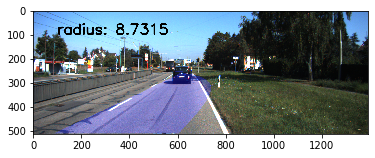

(512, 1392, 3)

In [118]:
# image = extract_frame('challenge_video.mp4', 10)
image = cv2.imread(r'.\data\data_1\data\0000000152.png')
K,D,crop,dest, src = problem[1]
result = lane_segmentation(image, crop, src, dest)
plt.imshow(result[:,:,::-1])
plt.show()
image.shape

In [119]:
C = cv2.VideoCapture('challenge_video.mp4')
out = cv2.VideoWriter('outfile.mp4', cv2.VideoWriter_fourcc(*'MP4V') , 15, (1280,720))
K,D,crop,dest, src = problem[2]
# frame = 0
while 1:
        ret, image = C.read()
#         frame+=1
        if ret == True:
#             print(frame, end='\r')
            try:
                image = lane_segmentation(image, crop, src, dest)
            except Exception as e:
#                 print(e)
                pass
#             cv2.imshow('result', image)
            out.write(image)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
        else:
            break
C.release()
out.release()
cv2.destroyAllWindows()
    

In [107]:
C.release()
out.release()
cv2.destroyAllWindows()

In [113]:
import os
os.listdir(r"./data/data_1/data/")

['0000000000.png',
 '0000000001.png',
 '0000000002.png',
 '0000000003.png',
 '0000000004.png',
 '0000000005.png',
 '0000000006.png',
 '0000000007.png',
 '0000000008.png',
 '0000000009.png',
 '0000000010.png',
 '0000000011.png',
 '0000000012.png',
 '0000000013.png',
 '0000000014.png',
 '0000000015.png',
 '0000000016.png',
 '0000000017.png',
 '0000000018.png',
 '0000000019.png',
 '0000000020.png',
 '0000000021.png',
 '0000000022.png',
 '0000000023.png',
 '0000000024.png',
 '0000000025.png',
 '0000000026.png',
 '0000000027.png',
 '0000000028.png',
 '0000000029.png',
 '0000000030.png',
 '0000000031.png',
 '0000000032.png',
 '0000000033.png',
 '0000000034.png',
 '0000000035.png',
 '0000000036.png',
 '0000000037.png',
 '0000000038.png',
 '0000000039.png',
 '0000000040.png',
 '0000000041.png',
 '0000000042.png',
 '0000000043.png',
 '0000000044.png',
 '0000000045.png',
 '0000000046.png',
 '0000000047.png',
 '0000000048.png',
 '0000000049.png',
 '0000000050.png',
 '0000000051.png',
 '0000000052